# Import Data

In [10]:
import numpy as np
np.random.seed(1248)
import tensorflow as tf
import keras

In [11]:
import pandas as pd

In [12]:
data = pd.read_csv('../data/buffer_overflow_data.csv.gz')

In [13]:
labels = data.copy()
del labels['Unnamed: 0']
del labels['Unnamed: 0.1']
del labels['filename']
del labels['code']
del labels['flaw']
del labels['flaw_loc']
labels = labels.drop_duplicates().sort_values('testcase_ID').reset_index(drop=True)

In [14]:
x = pd.read_csv("../data/buffer_overflow_graph_embeddings.csv.gz")
x['testcase_ID'] = x['type']
del x['type']
x = x.sort_values("testcase_ID").reset_index(drop=True)

In [15]:
y = labels['bug']
x = x.drop('testcase_ID', axis='columns')

In [16]:
import pickle

with open('../data/x-train-binary','rb') as f:
    x_train = pickle.load(f)
    
with open('../data/y-train-binary','rb') as f:
    y_train = pickle.load(f)
    
with open('../data/x-test-binary','rb') as f:
    x_test = pickle.load(f)
    
with open('../data/y-test-binary','rb') as f:
    y_test = pickle.load(f)

In [17]:
y_train.shape

(17201,)

In [18]:
x_train.shape

(17201, 128)

# Baseline Neural Network

In [19]:
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv1D, MaxPooling1D, Conv2D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.layers import RepeatVector, Permute, Lambda, ActivityRegularization, AveragePooling1D
from keras.optimizers import Nadam, Adagrad
import math

In [20]:
import pickle

with open('../data/dense-model-binary','rb') as f:
    model = pickle.load(f)

Instructions for updating:
Colocations handled automatically by placer.


In [21]:
model.evaluate(x_test,y_test)

4301/4301 [==============================] - 0s 81us/step


[0.6999454139776214, 0.5040688212251586]

In [22]:
import seaborn as sns
from sklearn import metrics
import matplotlib

In [23]:
y_predict= model.predict(x_test)

In [24]:
import numpy as np

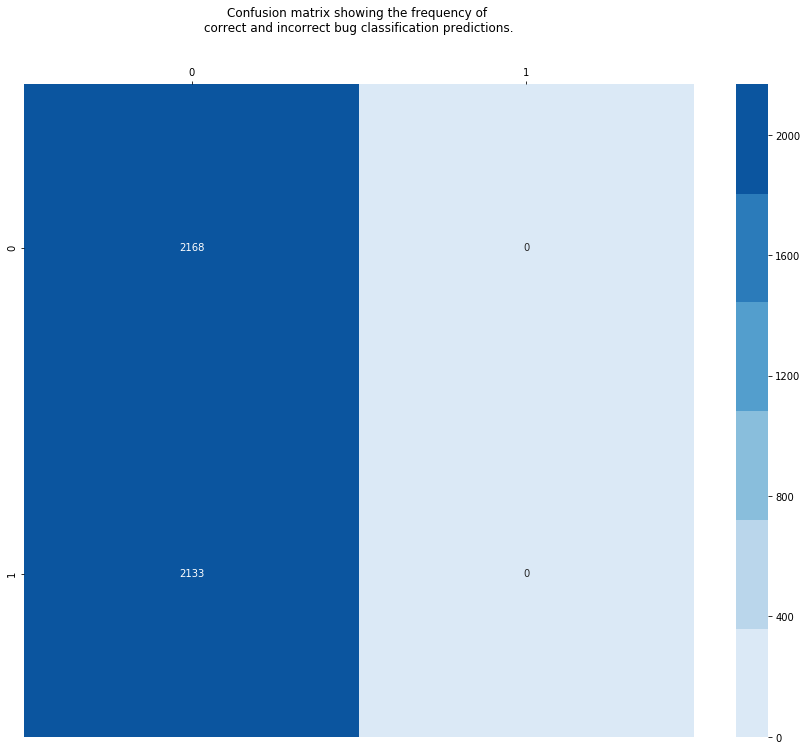

In [25]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_predict)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(15, 12)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

# Convolutional Neural Network

The functions below can be used as Neural Network layers if we want.

In [13]:
#What is K?

def antirectifier(x):
    x -= K.mean(x, axis=1, keepdims=True)
    x = K.l2_normalize(x, axis=1)
    pos = K.relu(x)
    neg = K.relu(-x)
    return K.concatenate([pos, neg], axis=1)

def antirectifier_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2  # only valid for 2D tensors
    shape[-1] *= 2
    return tuple(shape)

#conv_model.add(Lambda(antirectifier,output_shape=antirectifier_output_shape))


def hadamard_product_sum(tensors):
    out1 = tensors[0] * tensors[1]
    out2 = K.sum(out1, axis=-1)
    return [out1, out2]

def hadamard_product_sum_output_shape(input_shapes):
    shape1 = list(input_shapes[0])
    shape2 = list(input_shapes[1])
    assert shape1 == shape2  # else hadamard product isn't possible
    return [tuple(shape1), tuple(shape2[:-1])]

#conv_model(Lambda(hadamard_product_sum, hadamard_product_sum_output_shape))

Model justifications:

The first layer is a dense layer for ease of inputting our data as our data is not in the correct dimension to go straight into a nueral network.

The RepeatVector function is used to get the data into the desired dimesions, though it may not keep the proper structure we want. For unknown reasons, we were thrown errors when trying to use Reshape.

A 1-dimensional convulutional layer was added next, it moves along one axis as it convolutes. 

Strides controls how far it moves each iteration and it works best when set to move only one step.

The Sigmoid activation is most appropriate for our binary data as it is a logistic function.

A dropout function is incorporated to reduce the chance of overfitting. It is set at rate 0.5, input units to 0 at each update during the training time. 

We then pool using padding as 'same' so that everything is padded to the same length here.

We then flatten the data back to 2-dimensions.

Squaring everything helped with predictions as values close to 1 would get bigger and those close to 0 would get smaller.

We then finished with a dense layer.

In [26]:
conv_model = Sequential()

conv_model.add(Dense(128, input_dim=x_train.shape[1], activation='sigmoid'))
conv_model.add(RepeatVector(3))


# conv_model.add(Lambda(lambda x: x ** 3))

# conv_model.add(Permute(2,1))

conv_model.add(Conv1D(filters = 64, kernel_size = 3, strides = 1, activation ='sigmoid'))
conv_model.add(Dropout(0.5))
conv_model.add(MaxPooling1D(pool_size = 2, padding = 'same'))
# conv_model.add(Conv1D(filters = 64, kernel_size = 3, activation ='linear'))
# conv_model.add(LeakyReLU(alpha=0.1))
# conv_model.add(MaxPooling1D(pool_size = 2, padding = 'same'))
conv_model.add(Flatten())

conv_model.add(Lambda(lambda x: x**2))

conv_model.add(Dense(128, activation='sigmoid'))
# conv_model.add(LeakyReLU(alpha=0.1))
conv_model.add(Dropout(0.05))

conv_model.add(Dense(units=1, activation='sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [27]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 64)             24640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 64)                0         
__________

In [28]:
conv_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=Adadelta(), loss='binary_crossentropy', metrics=['accuracy'])
conv_model.fit(x_train, y_train, epochs=50, batch_size=64)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
17201/17201 [==============================] - 3s 163us/step - loss: 0.6956 - acc: 0.5215
Epoch 2/50
17201/17201 [==============================] - 2s 105us/step - loss: 0.6195 - acc: 0.6580
Epoch 3/50
17201/17201 [==============================] - 2s 128us/step - loss: 0.5256 - acc: 0.7364
Epoch 4/50
17201/17201 [==============================] - 2s 128us/step - loss: 0.4555 - acc: 0.7785
Epoch 5/50
17201/17201 [==============================] - 3s 158us/step - loss: 0.3929 - acc: 0.8076
Epoch 6/50
17201/17201 [==============================] - 2s 106us/step - loss: 0.3226 - acc: 0.8494
Epoch 7/50
17201/17201 [==============================] - 2s 113us/step - loss: 0.2536 - acc: 0.8856
Epoch 8/50
17201/17201 [==============================] - 2s 118us/step - loss: 0.2076 - acc: 0.9047
Epoch 9/50
17201/17201 [==============================] - 1s 86us/step - loss: 0.1806 - acc: 0.9172
Epoch 10/50
17201/17201 [===================

In [29]:
conv_model.evaluate(x_test,y_test)

4301/4301 [==============================] - 0s 88us/step


[0.10338481693725424, 0.9502441292722623]

In [37]:
import pickle

with open('../data/binary-convolutional','wb') as f:
    pickle.dump(conv_model,f)

In [30]:
y_predict_conv= conv_model.predict(x_test)

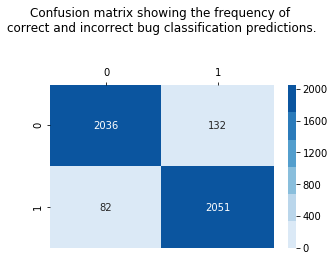

In [31]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_predict_conv)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 3)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [32]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, np.rint(y_predict_conv)).flatten().tolist()

fpr_cnn = fp/(fp+tp)
fnr_cnn = fn/(fn+tn)

In [33]:
fpr_cnn

0.060467246907924876

In [34]:
fnr_cnn

0.03871576959395656

In [35]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, matthews_corrcoef, f1_score, roc_auc_score
fpr_keras, tpr_keras, thresholds_keras = roc_curve((y_test.values+0), y_predict_conv)
precision, recall, thresholds = precision_recall_curve((y_test.values+0), y_predict_conv)

In [36]:
y_test_save = y_test.values+0

with open('../data/cnn-graph2vec-y-test', 'wb') as f:
    pickle.dump(y_test_save, f)
    
with open('../data/cnn-graph2vec-y-predict', 'wb') as f:
    pickle.dump(y_predict_conv, f)

In [25]:
auc_keras = auc(fpr_keras, tpr_keras)
roc_auc = roc_auc_score((y_test.values+0), y_predict_conv)
pr_auc = auc(recall, precision)
f1 = f1_score((y_test.values+0), np.rint(y_predict_conv))
mcc = matthews_corrcoef((y_test.values+0), np.rint(y_predict_conv))

In [26]:
print('PR AUC: %.3f' % pr_auc)
print('ROC AUC: %.3f' % roc_auc)
print('MCC: %.3f' % mcc)
print('F1: %.3f' % f1)

PR AUC: 0.995
ROC AUC: 0.995
MCC: 0.905
F1: 0.953


In [27]:
with open('../data/cnn-graph2vec-roc', 'wb') as f:
    pickle.dump(auc_keras, f)

with open('../data/cnn-graph2vec-pr', 'wb') as f:
    pickle.dump(roc_auc, f)

In [28]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.savefig('../images/baseline_roc_curve')

NameError: name 'plt' is not defined

### Train / Test / Val Split

In [15]:
with open('../data/x-train-binary-for-3-way-split','rb') as f:
    x_train1 = pickle.load(f)
    
with open('../data/y-train-binary-for-3-way-split','rb') as f:
    y_train1 = pickle.load(f)
    
with open('../data/x-val-binary','rb') as f:
    x_val = pickle.load(f)
    
with open('../data/y-val-binary','rb') as f:
    y_val = pickle.load(f)

In [16]:
conv_model.fit(x_train1, y_train1, validation_data = (x_val, y_val), epochs=50, batch_size=64)

Train on 15050 samples, validate on 2151 samples
Epoch 1/50
15050/15050 [==============================] - 1s 72us/step - loss: 0.0885 - acc: 0.9540 - val_loss: 0.0894 - val_acc: 0.9512
Epoch 2/50
15050/15050 [==============================] - 1s 91us/step - loss: 0.0904 - acc: 0.9506 - val_loss: 0.1336 - val_acc: 0.9433
Epoch 3/50
15050/15050 [==============================] - ETA: 0s - loss: 0.0883 - acc: 0.952 - 3s 172us/step - loss: 0.0883 - acc: 0.9528 - val_loss: 0.0872 - val_acc: 0.9572
Epoch 4/50
15050/15050 [==============================] - 1s 96us/step - loss: 0.0888 - acc: 0.9526 - val_loss: 0.0863 - val_acc: 0.9563
Epoch 5/50
15050/15050 [==============================] - 1s 89us/step - loss: 0.0868 - acc: 0.9550 - val_loss: 0.0845 - val_acc: 0.9558
Epoch 6/50
15050/15050 [==============================] - 1s 72us/step - loss: 0.0889 - acc: 0.9542 - val_loss: 0.0899 - val_acc: 0.9572
Epoch 7/50
15050/15050 [==============================] - 1s 74us/step - loss: 0.0858 - ac

In [17]:
conv_model.evaluate(x_test,y_test)

4301/4301 [==============================] - 0s 74us/step


[0.09072386094565392, 0.9530341781258334]

In [18]:
y_predict_conv1= conv_model.predict(x_test)

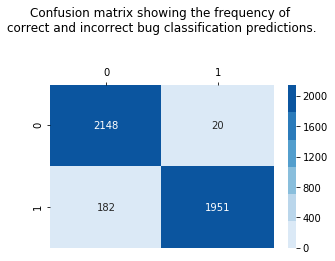

In [21]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_predict_conv1)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 3)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [22]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, np.rint(y_predict_conv1)).flatten().tolist()

fpr_cnn1 = fp/(fp+tp)
fnr_cnn1 = fn/(fn+tn)

In [23]:
fpr_cnn1

0.010147133434804667

In [24]:
fnr_cnn1

0.07811158798283262